# Pairs trading strategy
This notebook is based on quantopian lecture series.

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import quandl

## Simulation of cointegrated stocks

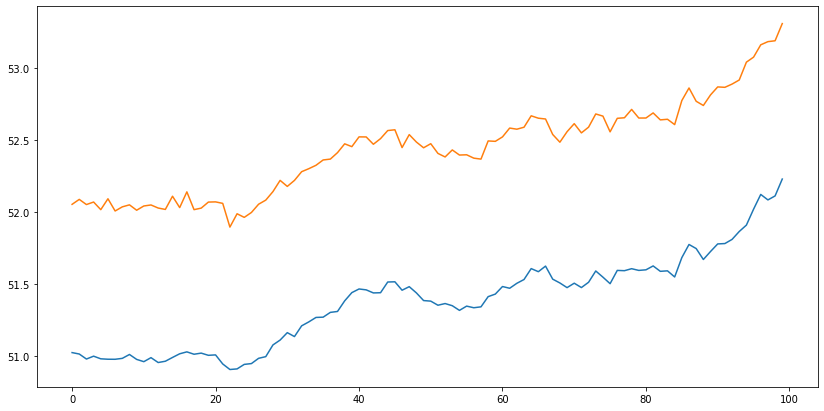

In [2]:
# just set the seed for the random number generator
np.random.seed(107)

# Simulate price movement and returns of one single stock
returns_1 = np.random.normal(1.01, 0.03, 100)
price_1 = pd.Series(np.cumprod(returns_1)) + 50
plt.figure(figsize=(14, 7))
price_1.plot()

# Random noise
noise = np.random.normal(1.01, 0.03, 100)
price_2 = price_1 + 0.05 + noise
price_2.plot()


Cointegration: -10.869241693624023
Cointegration p-value: 1.7282075267851952e-18
Correlation: 0.9955791800241492


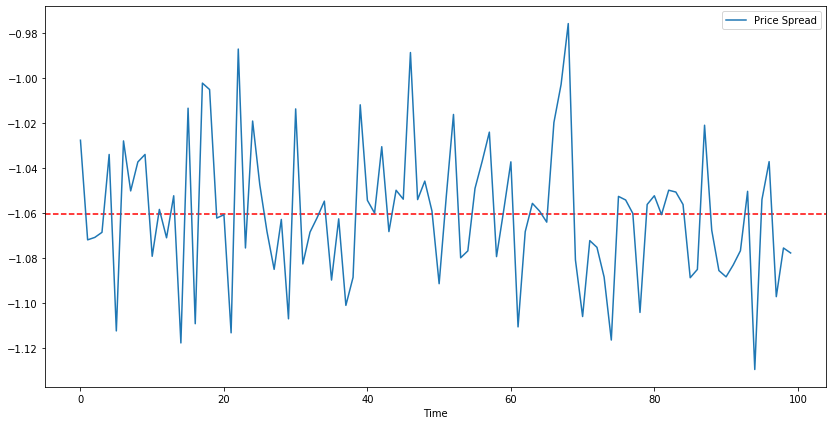

In [3]:
# Test visually for cointegration
spread = price_1 - price_2
plt.figure(figsize=(14, 7))
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread']);
spread.plot()

#Test statistically for cointegration
score, pvalue, _ = coint(price_1,price_2)
print ('Cointegration:', score)
print ('Cointegration p-value:', pvalue)
corr = price_1.corr(price_2)
print ('Correlation:', corr)

### Correlation without cointegration

Cointegration: -1.4571784126104588
Cointegration p-value: 0.7772435521033105
Correlation: 0.9638509893373488


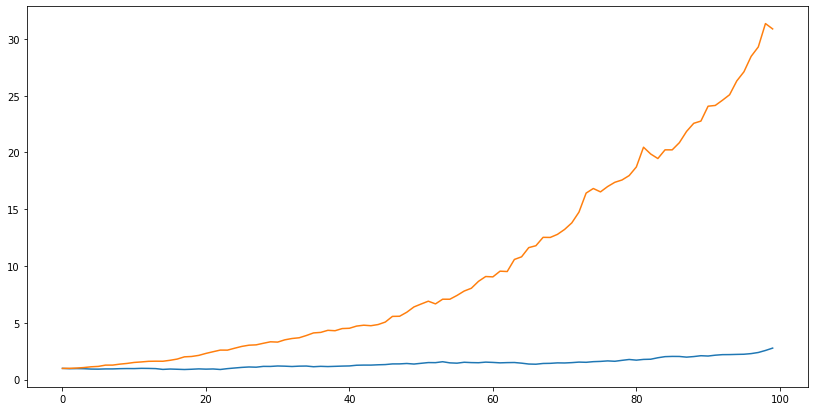

In [4]:
returns_3 = np.random.normal(1.01, 0.03, 100)
returns_4 = np.random.normal(1.035, 0.03, 100)

price_3 = pd.Series(np.cumprod(returns_3))
price_4 = pd.Series(np.cumprod(returns_4))
plt.figure(figsize=(14, 7))
price_3.plot()
price_4.plot()

#Test statistically for cointegration
score, pvalue, _ = coint(price_3,price_4)
print ('Cointegration:', score)
print ('Cointegration p-value:', pvalue)
corr = price_3.corr(price_4)
print ('Correlation:', corr)

### Cointegration without correlation

Cointegration: -11.623907616095428
Cointegration p-value: 2.7747435514326607e-20
Correlation: -0.05647565419813554


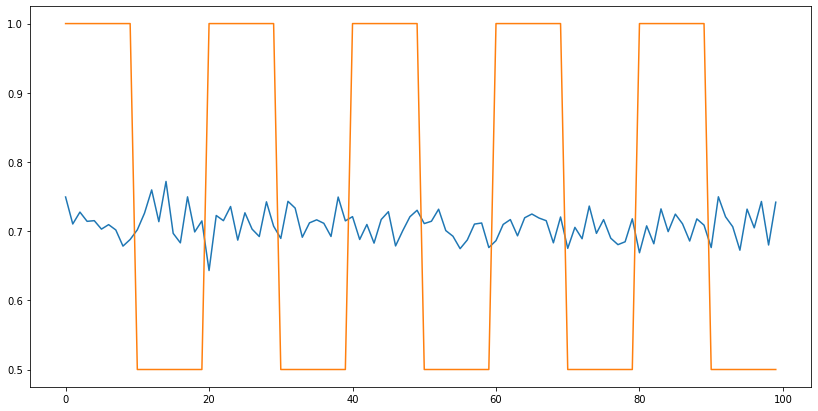

In [5]:
returns_5 = pd.Series(np.random.normal(1.01, 0.02, 100)- 0.3)
returns_6 = returns_5.copy()

# Y2 = Y2 + 10
returns_6[0:10] = 1
returns_6[10:20] = 0.5
returns_6[20:30] = 1
returns_6[30:40] = 0.5
returns_6[40:50] = 1
returns_6[50:60] = 0.5
returns_6[60:70] = 1
returns_6[70:80] = 0.5
returns_6[80:90] = 1
returns_6[90:100] = 0.5

plt.figure(figsize=(14, 7))
returns_5.plot()
returns_6.plot()

#Test statistically for cointegration
score, pvalue, _ = coint(returns_5,returns_6)
print ('Cointegration:', score)
print ('Cointegration p-value:', pvalue)
corr = returns_5.corr(returns_6)
print ('Correlation:', corr)

## Applying the principles

In [6]:
# Define function to find cointegrated pairs

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [7]:
# Import data for four major stocks from quandl

quandl.ApiConfig.api_key = 'is9J6Gdep3c_XZpxQu8h'
stocks = ['SPY','AAPL','ADBE','SYMC','EBAY','MSFT','QCOM','HPQ','JNPR','AMD','IBM']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close']},
                        date = { 'gte': '2013-1-1', 'lte': '2018-3-26' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2018-03-26,SYMC,26.21
1,2018-03-23,SYMC,25.70
2,2018-03-22,SYMC,26.60
3,2018-03-21,SYMC,26.93
4,2018-03-20,SYMC,26.52


In [8]:
# Transform the dataframe into a more handy format

df = data.set_index ('date')
table = df.pivot(columns = 'ticker')
columns = table.columns.get_level_values(1)
table.columns = columns
table.replace([np.inf, -np.inf], np.nan)
table.dropna(inplace = True)
table.head()

ticker,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,QCOM,SYMC
date,,,,,,,,,,
2013-01-02,71.195748,38.34,2.53,21.083176,6.001306,168.890592,19.534752,24.194478,56.006452,14.202225
2013-01-03,70.296565,37.75,2.49,20.634603,6.049253,167.961630,19.173525,23.870367,55.745492,14.140302
2013-01-04,68.338996,38.13,2.59,20.764509,6.049253,166.860637,19.373151,23.423618,54.925246,14.293288
2013-01-07,67.937002,37.94,2.67,21.051703,6.061240,166.129509,19.154513,23.379820,55.366378,14.315144
2013-01-08,68.119845,38.14,2.67,20.725168,6.149141,165.897268,18.745757,23.257183,55.279881,14.147587


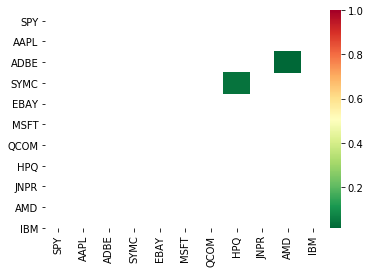

<Figure size 1008x504 with 0 Axes>

[('AMD', 'SYMC')]


In [9]:
# Look for cointegrated pairs
scores, pvalues, pairs = find_cointegrated_pairs(table)

# -- > AMD and SYMC are cointegrated
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=stocks, 
                yticklabels=stocks, cmap='RdYlGn_r', 
                mask = (pvalues >= 0.05))
plt.figure(figsize=(14, 7))
plt.show()
print(pairs)

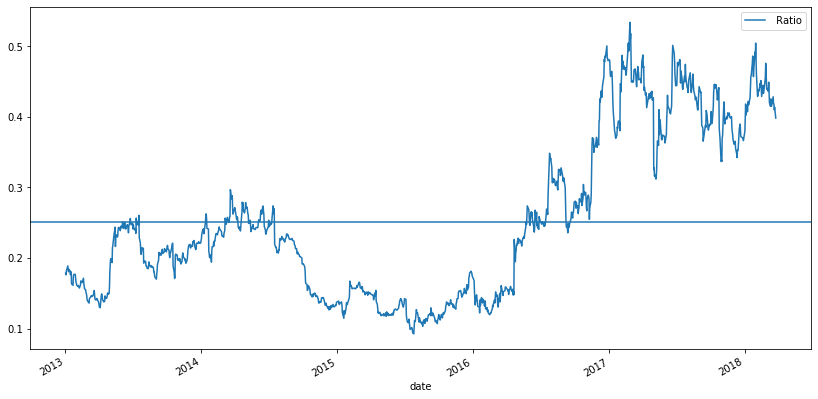

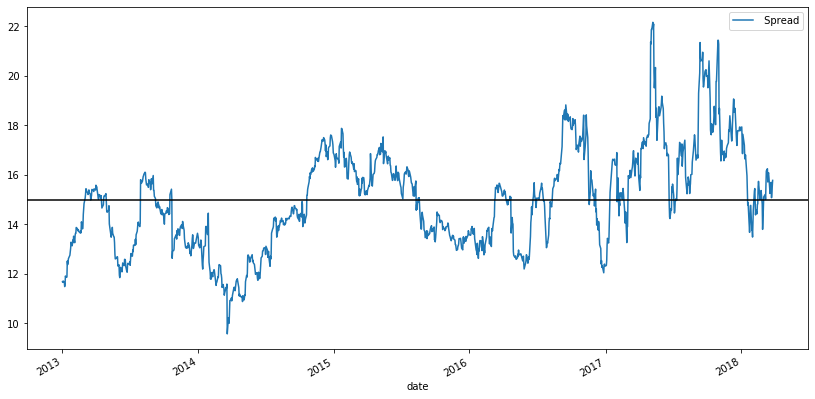

In [10]:
# Check the spread and the ratio to verify the calculated results

S1 = table['AMD']
S2 = table['SYMC']

score, pvalue, _ = coint(S1, S2)
pvalue

ratios = S1 / S2
spread = S2 - S1
plt.figure(figsize=(14, 7))
ratios.plot()
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()


plt.figure(figsize=(14, 7))
spread.plot()
plt.legend([' Spread'])
plt.axhline(spread.mean(), color='black')
plt.show()


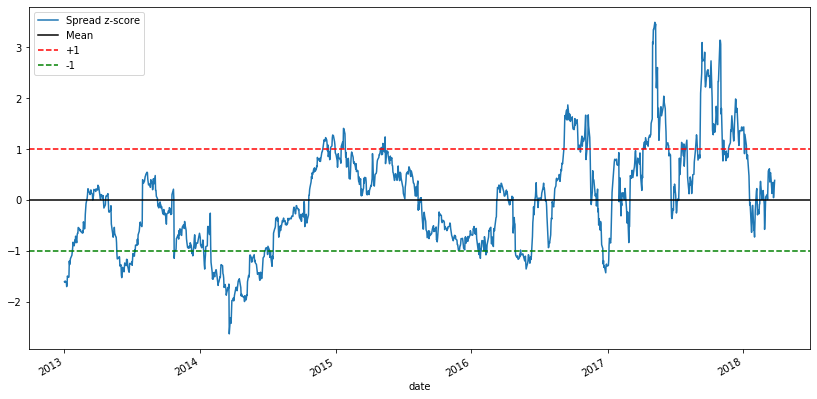

In [11]:
# Calculate z-score

def zscore(series):
    return (series - series.mean()) / np.std(series)
plt.figure(figsize=(14, 7))
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);



In [12]:
table['zscore'] = zscore(spread)
table['spread'] = spread
table['signal'] = 0.0
table['signal_up'] = np.where(table['zscore'] > 1, 1.0, 0.0)  
table['signal_low'] = np.where(table['zscore'] < -1, -1.0, 0.0)  
table['positions_up'] = table['signal_up'].diff()
table['positions_low'] = table['signal_low'].diff()

<Figure size 432x288 with 0 Axes>

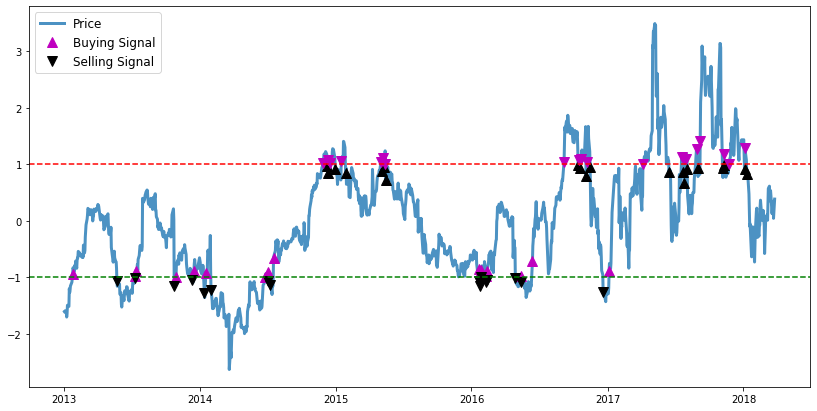

In [13]:
fig = plt.figure()
plt.figure(figsize=(14, 7))
plt.plot(table.index, table.zscore, lw=3, alpha=0.8,label='Price')
plt.plot(table.loc[table.positions_up == -1.0].index, table.zscore[table.positions_up == -1.0], '^', markersize=10, color='k')
plt.plot(table.loc[table.positions_up == 1.0].index, table.zscore[table.positions_up == 1.0],'v', markersize=10, color='m')
plt.plot(table.loc[table.positions_low == 1.0].index, table.zscore[table.positions_low == 1.0], '^', markersize=10, color='m', label = 'Buying Signal')
plt.plot(table.loc[table.positions_low == -1.0].index, table.zscore[table.positions_low == -1.0],'v', markersize=10, color='k', label = 'Selling Signal')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);
plt.legend(loc='upper left', fontsize=12)